# Cálculo de Enlace
## Edificio Libertador (EMGE) - Campo de Mayo (Telepuerto Satelital EA)
### Autor: CT Carlos MACEIRA GARCIA CONI
---

### Determinación del requerimiento:<br>
    a. Terminal A: Planta Transmisora EA (Campo de Mayo - PBA).
    b. Terminal B: EMGE (Edificio Libertador - CABA).
    c. Necesidades ancho de banda: 32 enlaces E1 y un enlace de 300 Mbps.
    d. Disponibilidad: 99.99%.

### Datos obtenidos del enlace:<br>
El tipo de terreno por donde se preveé instalar el enlace es llanura, pero debe tenerse
en cuenta que está la Ciudad Autónoma de Buenos Aires con sus edificaciones de gran altura en el camino. Los datos
obtenidos provenientes de relevamientos del Instituto Geográfico Nacional se agregan como un archivo de valores
separados por comas. Los mismo corresponden a un levantamiento que alturas que incluye las edificiaciones y accidentes
artificiales con una resolución de 5 metros cuadrados y consta de 1300 puntos. (Agradecimiento por la colaboracion con los datos al Alumno
Gabriel De Luca de la carrera de Ingeniería en Agrimensura).

![alt text](img/fuente_datos.jpeg)

In [1]:
# Librerías de manejo de datos y de graficación
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [2]:
# Lectura de los datos geográficos.
datos = pd.read_csv('data/puntosZ.csv', index_col='fid')
datos.head()

,LATITUD,LONGITUD,PROGRESIVA,Z
fid,,,,
1,-34.549768,-58.643817,0.00,18.03
2,-34.549815,-58.643605,20.11,14.37
3,-34.549861,-58.643393,40.23,13.89
4,-34.549908,-58.643182,60.34,13.64
5,-34.549954,-58.642970,80.46,12.85


El tipo de suelo predominante en el trayecto considerado es zona urbana, por
lo cual su conductividad $\sigma$ es de $7.5\times10^{-4}$ y su
permisividad es despreciable.

El clima de esta región es una variación del subtropical húmedo, también llamado templado, que se caracteriza porque la
estación más cálida es también la más lluviosa. Presenta veranos cálidos e inviernos frescos y variables, con heladas
frecuentes pero sin nevadas; la temperatura media anual es de 17 °C.

El coíndice de refraccion para la zona según el Anexo 1 la recomendación UIT-R P.453-14 es de $N_0 = 350$ en
febrero y $N_0 = 330$ en agosto, y el gradiente de refractividad $\frac{\delta N}{\delta h} = 50$. Los vientos para la
zona de acuerdo a los datos recabados de https://windy.app/ son:

![alt text](img/vientos_caba.png)

De acuerdo a la tabla 1 de Zonas Hidrometeorológicas de la recomendación UIT-R P.837-1 la zona de trabajo es K. La media
 anual de precipitación es de 1236,3 mm.
La ubicación geográfica y altura de los puntos terminales es:

In [3]:
# Extracción de los datos de los terminales del dataframe.
datos_terA = {'latitud':datos.iloc[0]['LATITUD'],
              'longitud':datos.iloc[0]['LONGITUD'],
              'altura':datos.iloc[0]['Z']}
datos_terB = {'latitud':datos.iloc[-1]['LATITUD'],
              'longitud':datos.iloc[-1]['LONGITUD'],
              'altura':datos.iloc[-1]['Z']}
print('Terminal A (Planta Transmisora):')
pprint.pprint(datos_terA)
print('Terminal B (Edificio Libertador):')
pprint.pprint(datos_terB)

Terminal A (Planta Transmisora):
{'altura': 18.03, 'latitud': -34.549768, 'longitud': -58.643817000000006}
Terminal B (Edificio Libertador):
{'altura': 48.26, 'latitud': -34.610084, 'longitud': -58.368091}


#### Perfil topográfico del terreno
Con los datos cargados se confecciona el gráfico del perfil topográfico real.

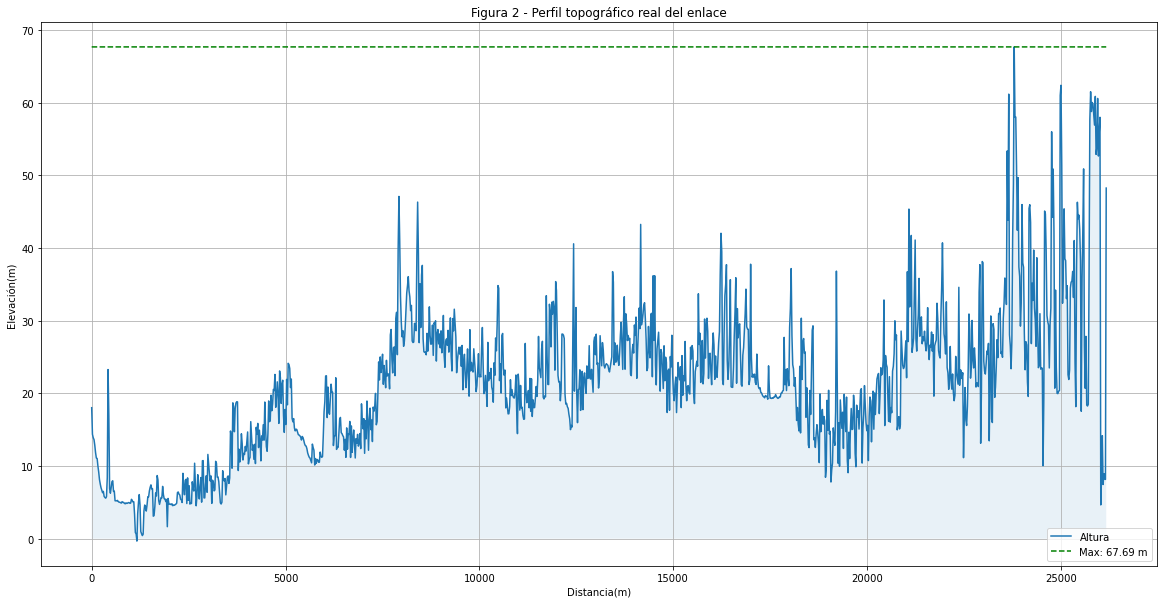

La máxima altura del perfil es: 67.69m a los 23794.89m de enlace 
La distancia de enlace es de 26168.35m


In [4]:
# Obtención de la máxima altura del perfil.
maxima_altura = datos['Z'].max()
posicion_maxalt = datos.loc[datos['Z'] == maxima_altura, 'PROGRESIVA'].iloc[0]
fig = plt.figure(figsize=(20,10))
# Confección del perfil y marcado de la línea de la máxima altura.
plt.plot('PROGRESIVA','Z', data=datos, label='Altura')
vector_max = np.full(len(datos), maxima_altura)
plt.plot('PROGRESIVA',vector_max,'--g',label='Max: '+str(maxima_altura)+' m', data=datos)
plt.fill_between(datos['PROGRESIVA'],datos['Z'],alpha=0.1)
plt.xlabel("Distancia(m)")
plt.ylabel("Elevación(m)")
plt.title("Figura 2 - Perfil topográfico real del enlace")
plt.grid()
plt.legend()
plt.show()

print("La máxima altura del perfil es: {}m a los {}m de enlace ".format(maxima_altura, posicion_maxalt))
print("La distancia de enlace es de {}m".format(datos.iloc[-1]['PROGRESIVA']))

### Repetidores Pasivos
Dado el perfil topográfico del enlace directo (Figura 2) no se aprecia necesaria la instalación de repetidores pasivos.

### Equipo preseleccionado
A fin de utilizar los parámetros de algun equipo disponible en el mercado se preselecciona al Bridge AP de la marca
Ubiquiti PowerBeam® 5AC Gen 2, el cual en una primera revisión satisfaría los requerimientos solicitados.
Su datasheet es completo y puede ser consultado en la siguiente URL:

https://dl.ubnt.com/datasheets/PowerBeam_ac_ISO/PowerBeam_AC_Gen2_DS.pdf

Este equipo incluye en un solo componente la electrónica y la antena, por lo cual no necesita de guías de onda ni de
conectores de RF, reduciendo las pérdidas. Los datos llegan hasta la antena a través de su puerto Gigabit Ethernet. Opera
en la banda de frecuencia de 5.1 a 5.8 GHz, posee una Ganancia de 25 dBi y alimentación mediante PoE.
Se utilizara para los cálculos el canal cuya frecuencia central está en $5.2 GHz$

In [5]:
fr = 5.2e9

### Frecuencia de transmision y ancho de banda requerido
El requerimiento del enlace especifica la necesidad de transmitir 32 canales E1 y un canal de datos de 300 Mbps. Dado
que la distancia de enlace es de 26,168 Km se elige aprovechar la banda no licenciada de 5150 - 5875 Mhz. Para hallar el
ancho de banda necesario:

$$R_{bit}= 32 \times E1 + Datos = 32 \times 2,048 Mbps + 300 Mbps = 365,536Mbps$$
$$R_{bitc}=\frac{R_{bit}}{FEC}=\frac{365,536Mbps}{5/6}=438,6432Mbps$$

Si la modulacion es 256QAM:

$$R_{simb}=\frac{R_{bitc}}{\log_2{m}}=\frac{438,6432Mbps}{\log_2{256}}=54,8304MBd$$
$$Bw_{rf}=1,2\times R_{simb} = 1,2\times R_{54,8304MBd} = 65,8 Mhz$$

### Longitud de onda
Para la banda no licencia de 5150 - 5875 Mhz la eleccion del canal que se configure en el equipo depende de un
relevamiento de la disponibilidad de canales a realizar en cada uno de los sitios de instalación, quedando fuera del
alcance del presente trabajo. Sin embargo la longitud de onda de la banda es de $5,17 cm $

### Nuevos perfiles de terreno segun los valores de K
Con los datos recabados el gradiente de refractividad para verano es $\frac{\delta N}{\delta h} = 50$. El
cálculo del valor del Factor K para obtener el radio equivalente de la tierra se expresa a continuación:

$$ K = a \left (157+ \frac{\delta N}{\delta h} \right)\times 10^{-6}$$
$$ K = 6370 \left (157+ 50 \right)\times 10^{-6} = 1,319$$

Aplicando este factor al perfil de la figura 2:

In [6]:
# Calculo del valor de K
radio_tierra = 6370
gradiente = 50
K = radio_tierra*(157 + gradiente) * 10 ** -6

#### Cálculo del despejamiento
Para realizar la corrección de la superficie terrestre a partir del valor de K obtenido a fin de que asegurar que llegue
toda la potencia prevista al receptor y no se produzcan atenuaciones por obstáculos se calcula $f(x)$ que representa
para cada punto de la distancia del enlace en cuánto se debe variar la cota topográfica para suponer que el enlace es
una recta.

$$f(x) = 0,07849 \times \frac{x\times (d-x)}{K} $$

In [7]:
# Cálculo del despejamiento f(x) = 0.07489 * ((x * (d - x))/ K) para cada punto de dato.
x = np.array(datos['PROGRESIVA']) * (10 ** -3)
d = datos.iloc[-1]['PROGRESIVA'] * (10 ** -3)
despejamiento = 0.07849 * ((x * (d - x))/ K)

El vector despejamiento se suma al vector de cotas topográficas para obtener el perfil ficticio.

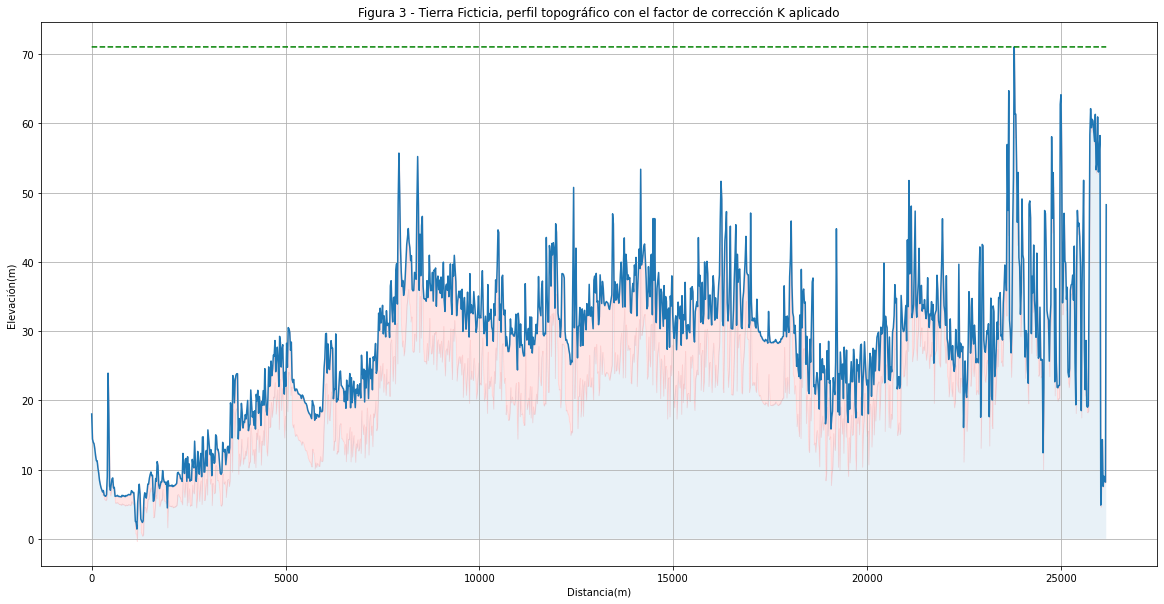

La máxima altura del perfil es: 71.05178681616478m a los 23794.89m de enlace 


In [8]:
# Confección del perfil de la tierra ficticia.
datos['Z_equivalente'] = datos['Z'] + despejamiento
# Se actualiza el valor de maxima_altura para reflejar el mismo despues de aplicar la corrección.
maxima_altura = datos['Z_equivalente'].max()
posicion_maxalt = datos.loc[datos['Z_equivalente'] == maxima_altura, 'PROGRESIVA'].iloc[0]

fig = plt.figure(figsize=(20,10))
plt.plot('PROGRESIVA','Z_equivalente', data=datos, label='Altura ficticia')
vector_max = np.full(len(datos), maxima_altura)
plt.plot('PROGRESIVA',vector_max,'--g',label='Max: '+str(maxima_altura)+' m', data=datos)
plt.fill_between(datos['PROGRESIVA'],datos['Z'],alpha=0.1)
plt.fill_between(datos['PROGRESIVA'],datos['Z'],datos['Z_equivalente'],alpha=0.1, color='red')
plt.xlabel("Distancia(m)")
plt.ylabel("Elevación(m)")
plt.title("Figura 3 - Tierra Ficticia, perfil topográfico con el factor de corrección K aplicado")
plt.grid()
plt.show()
# Observese el nuevo valor de maxima altura.
print("La máxima altura del perfil es: {}m a los {}m de enlace ".format(maxima_altura, posicion_maxalt))

Donde la zona sombreada en color rojo representa la variación causada por $f(x)$. Observese el nuevo valor de máxima
altura.

### Cálculo de la Zonas de Fresnel
A partir de los datos del enlace se calculan y reservan los datos de las curvas que conforman la primera y segunda zona
de Fresnel. Se aplican a los valores de los vectores las ecuaciones:
Para el calculo de la primera zona

$$ R1 = \sqrt{ \frac {d_1 d_2 \lambda}{d} } $$

In [9]:
distancias_rev = np.array(datos['PROGRESIVA'].sort_values(ascending=False))
distancia_total = distancias_rev[0]
c = 3e8 #m/s velocidad de la luz
longitud_onda = c / fr
datos['primera_zf_sup'] = np.sqrt((np.array(datos['PROGRESIVA']) * distancias_rev * longitud_onda)/distancia_total)
datos['primera_zf_inf'] = (datos['primera_zf_sup'] * -1)
datos['segunda_zf_sup'] = datos['primera_zf_sup'] * (2 ** 0.5)
datos['segunda_zf_inf'] = datos['primera_zf_inf'] * (2 ** 0.5)
print(f'El radio máximo de la primer zona de Fresnel es de: {datos["primera_zf_sup"].max()}')
print(f'El radio máximo de la segunda zona de Fresnel es de: {datos["segunda_zf_sup"].max()}')

El radio máximo de la primer zona de Fresnel es de: 19.427503753756714
El radio máximo de la segunda zona de Fresnel es de: 27.47463929161696


### Trazado de la Zonas de Fresnel segun la condición de despejamiento para la peor situación
Dado que se conoce la máxima altura del perfil ficticio, y la condición de despejamiento para frecuencias mayores a 3
Ghz requiere un 100% de la R1 y 30% de la R2 despejada, se grafica las zonas de Fresnel en el perfil, sin ninguna
optimización en cuanto a las anlturas de las antenas en azimuth.

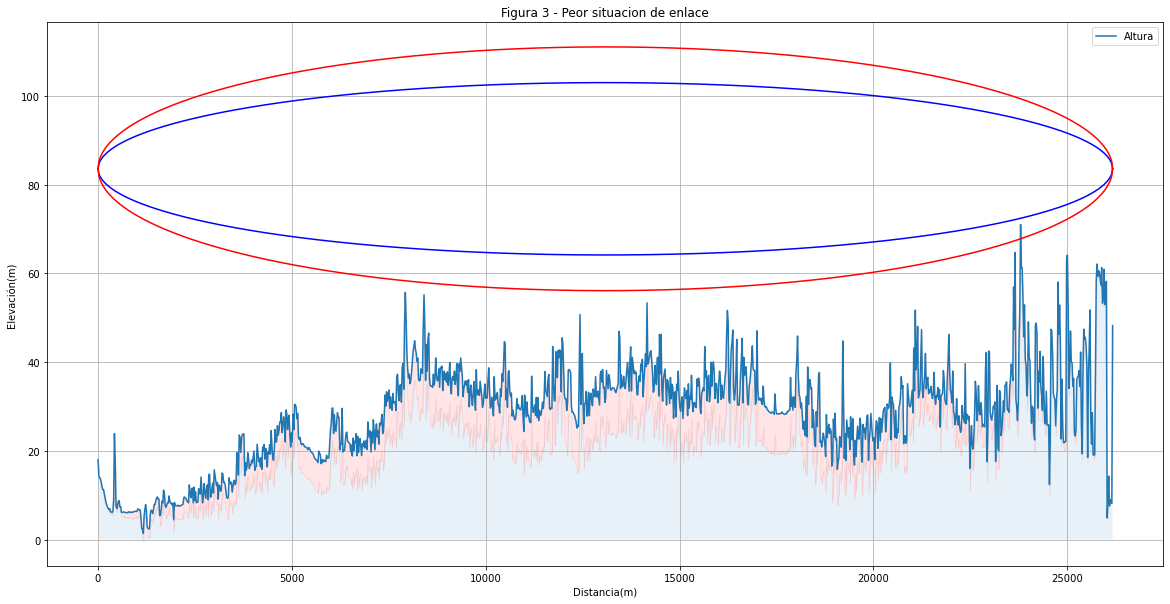

In [10]:
#Calculo del despejamiento del 30% necesario para la segunda zona de Fresnel.
despejamiento_segunda_zf = (datos.loc[datos['Z_equivalente'] == maxima_altura, 'segunda_zf_inf'].iloc[0] -
                            datos.loc[datos['Z_equivalente'] == maxima_altura, 'primera_zf_inf'].iloc[0]) * 0.7
elevacion = maxima_altura + abs(datos.loc[datos['Z_equivalente'] == maxima_altura, 'segunda_zf_inf'].iloc[0]  - despejamiento_segunda_zf)
#Graficación
fig = plt.figure(figsize=(20,10))
plt.plot('PROGRESIVA','Z_equivalente', data=datos, label='Altura')
plt.plot(datos['PROGRESIVA'], datos['primera_zf_sup'] + elevacion, color='blue')
plt.plot(datos['PROGRESIVA'], datos['primera_zf_inf'] + elevacion, color='blue')
plt.plot(datos['PROGRESIVA'], datos['segunda_zf_sup'] + elevacion, color='red')
plt.plot(datos['PROGRESIVA'], datos['segunda_zf_inf'] + elevacion, color='red')
plt.fill_between(datos['PROGRESIVA'],datos['Z'],alpha=0.1)
plt.fill_between(datos['PROGRESIVA'],datos['Z'],datos['Z_equivalente'],alpha=0.1, color='red')
plt.xlabel("Distancia(m)")
plt.ylabel("Elevación(m)")
plt.title("Figura 3 - Peor situacion de enlace")
plt.grid()
plt.legend()
plt.show()

Esta ubicación de los equipos es poco conveniente debido a la gran altura que debe tener una de las torres, situación que
puede no ser deseable. Se plantea hallar la ecuación de una recta de la forma $ y = mx + b $ tal que minimice la altura de
ambas torres, sin perder el despejamiento. Para ello se plantea obtener las coordenadas de los puntos de mayor altura de
 la primera y segunda mitad del trayecto de enlace y con esos puntos hallar la pendiente y ordenada al origen.

La ecuacion de la recta de enlace es y = 0.0009663344896970469x + 48.05796393061741


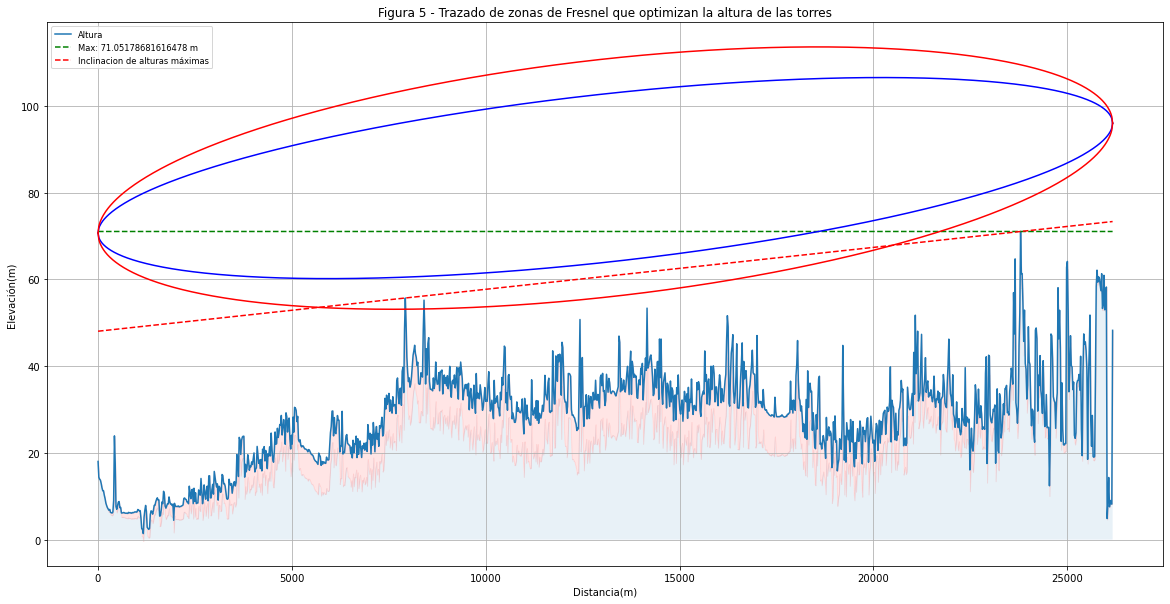

In [12]:
# Busqueda de la recta que optimice las alturas de las torres aplicandole inclinacion al enlace
def hallar_recta(datos):
    #Funcion que dado un datagrama con datos de altura devuelve los parametros de la recta de maximas alturas
    alturas = np.array(datos['Z_equivalente'])
    primer_mitad, segunda_mitad = np.array_split(alturas, 2)
    y1 = primer_mitad.max()
    y2 = segunda_mitad.max()
    x1 = datos.loc[datos['Z_equivalente'] == y1, 'PROGRESIVA'].iloc[0]
    x2 = datos.loc[datos['Z_equivalente'] == y2, 'PROGRESIVA'].iloc[0]
    m = (y2 - y1)/(x2 - x1)
    b = y1 - (m * x1)
    return m,b,y1,y2
m,b,y1,y2 = hallar_recta(datos)
print(f'La ecuacion de la recta de enlace es y = {m}x + {b}')

# Como ahora al inclinar el enlace se afecta el despejamiento en otro punto del mismo se debe calcular nuevamente
despejamiento_segunda_zf = (datos.loc[datos['Z_equivalente'] == y1, 'segunda_zf_inf'].iloc[0] -
                            datos.loc[datos['Z_equivalente'] == y1, 'primera_zf_inf'].iloc[0]) * 0.7
# Margen de seguridad del 50%
despejamiento_segunda_zf -= despejamiento_segunda_zf * 0.5
elevacion = abs(datos.loc[datos['Z_equivalente'] == y1, 'segunda_zf_inf'].iloc[0]  - despejamiento_segunda_zf)
datos['linea_optima'] = m * datos['PROGRESIVA'] + b
fig = plt.figure(figsize=(20,10))
plt.plot('PROGRESIVA','Z_equivalente', data=datos, label='Altura')
plt.plot('PROGRESIVA',vector_max,'--g',label='Max: '+str(maxima_altura)+' m', data=datos)
plt.plot('PROGRESIVA','linea_optima','--r',label='Inclinacion de alturas máximas', data=datos)
plt.plot(datos['PROGRESIVA'], datos['primera_zf_sup'] + datos['linea_optima'] + elevacion, color='blue')
plt.plot(datos['PROGRESIVA'], datos['primera_zf_inf'] + datos['linea_optima'] + elevacion, color='blue')
plt.plot(datos['PROGRESIVA'], datos['segunda_zf_sup'] + datos['linea_optima'] + elevacion, color='red')
plt.plot(datos['PROGRESIVA'], datos['segunda_zf_inf'] + datos['linea_optima'] + elevacion, color='red')
plt.fill_between(datos['PROGRESIVA'],datos['Z'],alpha=0.1)
plt.fill_between(datos['PROGRESIVA'],datos['Z'],datos['Z_equivalente'],alpha=0.1, color='red')
plt.xlabel("Distancia(m)")
plt.ylabel("Elevación(m)")
plt.title("Figura 5 - Trazado de zonas de Fresnel que optimizan la altura de las torres")
plt.grid()
plt.legend(fontsize='small')
plt.show()

Este gráfico ya incluye el margen de seguridad del 50% para asegurar la estabilidad del enlace a pesar de variaciones
del perfil del terreno y el clima. Tenemos las siguientes alturas de los equipos:

In [ ]:
print('Altura de Terminal A: {}'.format(datos['linea_optima'].iloc[0] + elevacion))
print('Altura de Terminal B: {}'.format(datos['linea_optima'].iloc[-1] + elevacion))

### Cálculo de pérdidas
#### Pérdidas en espacio libre

$$ A_0 = 20\log \left ( \frac{4 \pi r f}{c} \right ) $$

In [ ]:
at_0 = 20 * np.log10((4 * np.pi * distancia_total * 5.3e9)/(3e8))
print("La atenuación en espacio libre es de {}".format(at_0))

#### Pérdidas por conectores y guías de onda
Para este estudio y en base a las especificaciones del equipo seleccionado no se consideran estas pérdidas dado que
antena y electronica conforman una misma ODU.

In [ ]:
L = 0

#### Pérdidas por lluvias
Según la tabla zonas hidrometeorológicas de la recomendación UIT-R P.837-1 la zona de instalación se corresponde con la
zona K. Dada la frecuencia de operación de 5.8 GHz recién comienzan a ser significativas las pérdidas a partir de los
70 mm/h, pero para la zona antedicha esto ocurre un 0,003% del tiempo, o sea 1 día al año.

### Potencia de transmisión en dB del equipo
Se considera una potencia de transmisión de equipo estándar de 20dBm en base a especificaciones de un fabricante (Ubiquiti)
para el tipo de modulacion analizado 256QAM.

In [ ]:
pt_dbm = 20

### Ganancia de la antena
Se considera una ganancia de antena de 25dBi en base a especificaciones de un equipo seleccionado como candidato a ser
seleccionado.

In [ ]:
gt_dbi = 25
gr_dbi = 25

### Atenuacion total
Con los datos antes expuestos el calculo de la atenuación total es:

$$ A_t = A_0 + L - G_e -G_r $$

In [ ]:
at = at_0 + L - gr_dbi - gt_dbi
print("La atenuación total del sistema es de: {} db. ".format(at))

### Balance de potencia
El calculo del balance de potencia permite saber si potencia de transmision es compatible con la atenuacion del sistema
y la sensibilidad de recepcion. Debe ser igual o mayor a cero, cuanto mayor es mas deseable.

In [ ]:
Sr = 65 #Sensibilidad en dBm
balance = pt_dbm - at + Sr
print("El balance de potencia es de {} dB.".format(balance))


Se observa que da por debajo de cero, esto no es deseable, ya que cualquier minima variacion puede provocar la degradacion
del enlace. Sin embargo, para el equipo propuesto PBE-5AC-ISO-Gen2 de Ubiquiti, se encuentra al limite de sus capacidad.
Una posible solución a este problema y siendo recomendable en enlaces de tipo critico es la instalacion de dos pares de
equipos en diversidad. Esto permitira bajar el FEC, la modulacion y consecuentemente el ancho del canal, lo cual según
la hoja de datos del mismo incrementa su potencia media de transmisión y la sensibilidad de recepción.